In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from string import punctuation
import sys

Pretprocesiranje

In [2]:
df = pd.read_csv('emotions_dataset.csv')

for text in df['Text']:
    text = text.lower()

In [21]:
emotion_set = (set(df['Emotion'][:]))
emotion_map = {}

i = 0;
for emotion in emotion_set: 
    emotion_map[emotion] = i
    i = i+1;    

del i
  
df['Emotion'] = df['Emotion'].map(emotion_map)

print ("emotion_map: ", emotion_map)
df.head(5)

%run Auxiliary.ipynb

emotion_map:  {'surprise': 0, 'sadness': 1, 'anger': 2, 'happy': 3, 'love': 4, 'fear': 5}
Emotion count {'sadness': 6265, 'anger': 2993, 'love': 1641, 'surprise': 879, 'fear': 2652, 'happy': 7029}


In [4]:
#We are counting frequenceies of all words
counts = Counter();

for num, text in enumerate(df['Text']):
    tmp_text = "".join([c if c not in punctuation else ' ' + c + ' ' for c in text])
    df.loc[num, 'Text'] = tmp_text
    counts.update(tmp_text.split())
    
word_counts = sorted(counts, key = counts.get, reverse = True)
word_to_int = {word : i for i, word in enumerate(word_counts, 1)}

In [5]:
mapped_texts = []
for text in df['Text']:
    tmp_l = []
    for word in text.split():
        try:
            tmp_l.append(word_to_int[word])
        except:
            print("Rec koju ne mogu da prepoznam je ", word)
            sys.exit()
            
            
    mapped_texts.append(tmp_l)

In [6]:
#We set sequence_length to a number we preffer out model to train text messages by.
#If we set sequence_length to 50 then model will truncate all texts to fit.
sequence_length = 0
for seq in mapped_texts:
    sequence_length = max(sequence_length, len(seq))
print(sequence_length)

66


In [7]:
#Now we create sequences of same length
sequences = np.zeros((len(mapped_texts), sequence_length), dtype = int)

for i, row in enumerate(mapped_texts):
    text_arr = np.array(row)
    sequences[i, -len(row):] = text_arr[-sequence_length :]

print("We transformed ", mapped_texts[0], " into => \n", sequences[0])

We transformed  [1, 148, 2, 670]  into => 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1 148   2 670]


In [54]:
#21459 samples in the dataset. We split the data into training and test set
X_train = sequences[:15000, :]
y_train = df.loc[:14999, 'Emotion'].values
y_train = pd.get_dummies(y_train)
X_test = sequences[15000:, :]
y_test = df.loc[15000:, 'Emotion'].values
print(X_train.shape)
print(y_train.shape)
print(sequence_length)

(15000, 66)
(15000, 6)
66


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Embedding, concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, SpatialDropout1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import sklearn.metrics as skm
import pandas as pd
import numpy as np

In [10]:
def create_cnn_lstm_model(max_words):
    model = Sequential()
    model.add(InputLayer(input_shape=(66,)))
    model.add(Embedding(len(max_words)+1, 6))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(100, recurrent_activation="sigmoid",
                    activation='tanh',
                    unroll = False,
                    dropout = 0.3,
                    use_bias = True,
                    return_sequences = True,
                    recurrent_dropout = 0)))

#     model.add(Conv1D(128, kernel_size = 8, padding = "same"))
#     model.add(LeakyReLU(0.08))
#     model.add(MaxPooling1D(4))
#     model.add(Dropout(0.5))

    model.add(Conv1D(256, kernel_size = 8, padding = "same"))
    model.add(LeakyReLU(0.08))
    model.add(MaxPooling1D(4))
    model.add(Dropout(0.5))

    model.add(Conv1D(512, kernel_size = 8, padding = "same"))
    model.add(LeakyReLU(0.08))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.5))

    model.add(Conv1D(512, kernel_size = 8, padding = "same"))
    model.add(LeakyReLU(0.08))
    model.add(MaxPooling1D(3))
    model.add(Dropout(0.5))
    
    model.add(GlobalMaxPooling1D())

    model.add(Dense(256))
    model.add(LeakyReLU(0.08))
    
    model.add(Dense(128))
    model.add(LeakyReLU(0.08))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0004),metrics=['acc'])
    model.summary()
    return model

In [11]:
model = create_cnn_lstm_model(word_to_int)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 66, 6)             119664    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 66, 6)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 66, 200)           85600     
_________________________________________________________________
conv1d (Conv1D)              (None, 66, 256)           409856    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 66, 256)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 256)           0

/home/darko/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=40, batch_size=8)

Epoch 1/40
1500/1500 [==============================] - 374s 246ms/step - loss: 1.5614 - acc: 0.3397 - val_loss: 1.3549 - val_acc: 0.3947
Epoch 2/40
1500/1500 [==============================] - 368s 245ms/step - loss: 1.1529 - acc: 0.5327 - val_loss: 0.8134 - val_acc: 0.6813
Epoch 3/40
1500/1500 [==============================] - 368s 245ms/step - loss: 0.8664 - acc: 0.6568 - val_loss: 0.6759 - val_acc: 0.7263
Epoch 4/40
1500/1500 [==============================] - 374s 249ms/step - loss: 0.7593 - acc: 0.7083 - val_loss: 0.5964 - val_acc: 0.7723
Epoch 5/40
1500/1500 [==============================] - 374s 250ms/step - loss: 0.6688 - acc: 0.7519 - val_loss: 0.5763 - val_acc: 0.8247
Epoch 6/40
1500/1500 [==============================] - 378s 252ms/step - loss: 0.5853 - acc: 0.7895 - val_loss: 0.4953 - val_acc: 0.8320
Epoch 7/40
1500/1500 [==============================] - 380s 253ms/step - loss: 0.5066 - acc: 0.8240 - val_loss: 0.4281 - val_acc: 0.8557
Epoch 8/40
1500/1500 [============

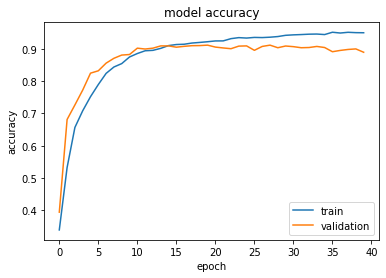

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [111]:
%run Auxiliary.ipynb
columns = list(emotion_set)

emotion_list = list(emotion_set)
model_evaluation(X_test, y_test, model, columns, word_to_int, emotion_list)

Emotion count {'sadness': 6265, 'anger': 2993, 'love': 1641, 'surprise': 879, 'fear': 2652, 'happy': 7029}
Confusion matrix
[[ 138   39   48   31   37   44]
 [   5 1600  140   48   76   16]
 [   5  139  734   37   38   16]
 [   3  108   99 1671  105    7]
 [   2    9    6   47  362    0]
 [  32  105  197   31   27  457]]


In [109]:
def predict_my_text(text, model, sequence_length, word_to_int, emotion_map):
        mapped_text = []
        for word in text.split():
            mapped_text.append(word_to_int(word))
        
        emotion = model.predict(emotion);
    
    
#Now we create sequences of same length
sequences = np.zeros((len(mapped_texts), sequence_length), dtype = int)

for i, row in enumerate(mapped_texts):
    text_arr = np.array(row)
    sequences[i, -len(row):] = text_arr[-sequence_length :]

print("We transformed ", mapped_texts[0], " into => \n", sequences[0])
    

In [110]:
my_text = "i like it"
predict_my_text(my_text, model, sequence_length, word_to_int, emotion_map)

[1, 13, 12]
